## Basic Setup

In [62]:
%pip install seaborn tikzplotlib
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import wandb
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tikzplotlib

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=True)

api = wandb.Api()

def restore_exp(n_docs, n_queries) -> (T5ForConditionalGeneration, list[str]):
    project_path = f'tribler/retrieval-{n_docs}'

    # restore model
    artifact = api.artifact(f'{project_path}/model_100_20:v0', type='model')
    artifact_dir = artifact.download()
    state_dict = torch.load(f'{artifact_dir}/model_100_20.pth', map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)

    # restore docids
    artifact_name = f'retrieval_test_{n_docs}_{n_queries}:latest'
    artifact = wandb.Api().artifact(f"{project_path}/{artifact_name}", type='results')
    artifact_dir = artifact.download()
    table = artifact.get(f'retrieval_test_{n_docs}_{n_queries}')
    df = pd.DataFrame(data=table.data, columns=table.columns)
    docids = df['test_output'].unique()

    return model, docids

def get_embedding(model, docid):
    input_ids = tokenizer(docid, return_tensors="pt").input_ids
    with torch.no_grad():
        encoder_outputs = model.encoder(input_ids=input_ids)
    last_hidden_states = encoder_outputs.last_hidden_state
    return last_hidden_states.mean(dim=1)

Note: you may need to restart the kernel to use updated packages.


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

model1, _ = restore_exp(100, 1)
model20, _ = restore_exp(100, 20)


wandb: Downloading large artifact model_100_20:v0, 230.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact model_100_20:v0, 230.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [72]:
deltas = []
for docid in docids:
    delta = cosine_similarity(
        get_embedding(model1, docid), 
        get_embedding(model20, docid)
    )
    deltas.append(delta.item())

print('Mean:', sum(deltas) / len(deltas))
print('Max:', max(deltas))

Mean: 1.0000000041723252
Max: 1.000000238418579


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

## Plotting

wandb: Downloading large artifact model_100_20:v0, 230.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


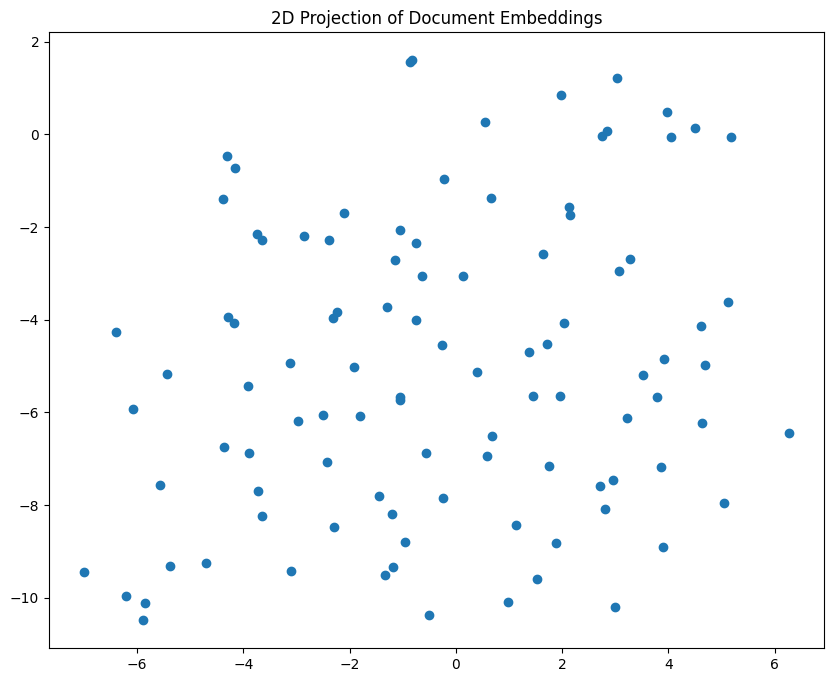

In [58]:
model, docids = restore_exp(100, 1)

embeddings = torch.stack([get_embedding(model, docid).squeeze(0) for docid in docids]).detach().numpy()

# Now apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# # Optionally add annotations
# for i, docid in enumerate(docids):
#     plt.annotate(docid, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.title('2D Projection of Document Embeddings')
plt.show()

## Export to TikZ/TeX

In [124]:
tikzplotlib.save(
    f'../plots/cluster_{n_queries}q_{n_docs}d_pop{min_pop}{"-" + str(max_pop) if max_pop is not None else ""}.tex',
    axis_width=r'\columnwidth', axis_height=r'6cm'
)

<Figure size 640x480 with 0 Axes>